# Machine learning

Dans cette partie, nous allons expliquer le cheminement utilisé pour développer le modèle de prédiction du prix de vente.  
Le fichier de prévisions possédant des valeurs manquantes sur **Type local**, nous avons décidé de faire en premier lieu un modèle de prévision du type local.

## Prédiction du type local

Pour prédire le type local, nous avons décidé de nous intéresser à des variables cohérentes pouvant nous donner l'information.
Nos premier choix ont été de selectionner quatres variables dans le jeu de donnée :
- __Surface reelle bati__
- __Nombre pieces principales__
- __Surface terrain__
- __Prix m2 moyen commune__


En effet, ces 4 variables semblent suffisantes pour estimer du type de local.  
Notamment __Surface terrain__, qui est égale à zéro pour les appartements. 

Cependant, après observation de notre data set, on se rend compte que les valeurs de __Surface terrain__ sont égale à NaN (=0),  
on peut donc uniquement prédire que c'est un zéro si **on a déja l'information du type local (Appartement)**.  
Attention au sur apprentissage.

On va donc se concentrer sur __Surface reelle bati__, __Nombre pieces principales__ et __Prix m2 moyen commune__ pour la suite.

### Arbre de décision

On utilise un arbre de décision pour prédire le type local.

En utilisant un **grid search** pour estimer les meilleurs paramètre du modèle, on lance nos générations de modèles sur nos variables, avec les paramètres suivants :
- Echantillon d'entrainement total (n = 1955342)
- `max_depth : [10, 20, 30]`
- `min_samples_split : [0.8, 0.6, 0.4, 0.2]`
- `min_samples_leaf : [0.8, 0.6, 0.4, 0.2]`

Le modèle offrant les meilleurs performances nous donne ces paramètre : max_depth = 10, min_samples_split = 0.2, min_samples_leaf = 0.4  
On va donc utiliser ces paramètres pour la suite de notre étude.

On va utiliser le modèle SHAP pour déduire les variables importante pour notre arbre.  
```python
import SHAP
```

Cela vas nous donner des graphiques de l'importances des différentes variables dans notre arbre.  
Il nous donne ce premier graphique.  

![Alt text](image.png)


Nombre de pièce principale n'impacte pas dans la prédiction.  
On peut donc simplifier le modèle en enlevant cette variable.  

On refait tourner notre modèle, et on trouve un score de précision de **79%**

En faisant tourner le modèle avec d'autres paramètres, nous n'observons pas d'augmentation signicative des performances du modèle, on décide donc de partir sur ce modèle :  

Arbre de décision sur __Surface reelle bati__, __Prix m2 moyen commune__ .

## Prédiction du prix de vente

Pour la prédiction du prix de vente, nous avons étudié plusieurs algorithmes de régression différents :
- __Régression linéaire__
- __Ridge__
- __Lasso__
- __SGDRegressor__
- __Random Forest regressor__

On fait quelques tests avec des variables "logiques" pour la prédiction du modèle, en incorporant nos variables open-data et du feature engineering.

Pour les variables : Surface reelle bati, Nombre pieces principales, Surface terrain, mois, année  
| Modèle | MSE |
| :------| :---|
| Régression linéaire | 731530613746 |
| Ridge | 8205344142 |
| Lasso | 8205348595 |

En regardant les correlations, on ne semble pas observer de réelles relations linéaire entre les variables.  
On décide de concentrer nos efforts sur les random forest.

Pour optimiser le temps, on décide de se concentrer uniquement sur deux modèles, SGD Regressor (Qui inclut les regression linéaire, ridge et lasso) et les random forest regressor.  
On garde SGD regressor juste pour observer l'impact de nos variables open data (latitude et longitude).  

Pour tester nos modèles, on prend des echantillons de n = 50 000 individus pour avoir un temps de calcul de Gridsearch raisonnable.


### SGD regressor

On réalise à peu près la même étude que pour le decision tree.  
On utilise Grid search pour observer les résultats de notre SGDregressor :
```python 
penalty : ['l2', 'l1', 'elasticnet', None] 
alpha : [0.001, 0.1 , 1 ,10 ,100 ,1000]
```  

On trouve les résultats suivants (2 exemples) : 

Uniquement sur les maisons  
n = 50 000  
Variables utilisées : Surface reelle bati, 'Prix m2 moyen commune, latitude, longitude  
**RMSE : 728213487134930.9 (squared=False)**  
**{'alpha': 1000, 'penalty': 'l2'}**  

Uniquement sur les appartements  
n = 50 000  
Variables utilisées : Surface reelle bati, 'Prix m2 moyen commune, latitude, longitude  
**RMSE : 217639111.33046177 (squared=False)**  
**{'alpha': 100, 'penalty': 'l1'}**  

Les résultats ne semble pas au niveau, on a donc décidé de se concentrer principalement sur un Random forest.


### Random forest regressor

Les correlations entre les différentes variables n'étant pas très elevé, nous esperons avoir de bon résultats avec random Forest.  
De plus, nous avons mis beaucoup d'espoir dans certains varibales (latitude et longitude) qui aurait permis à l'arbre de traduire le rapprochement des communes entre elles.

On initie le Random forest, et on teste plusieurs paramètres de grid search pour optimiser notre modèle.  

Nous allons evaluer notre modèle sur son RMSE, et visualiser l'impact des variables à travers une analyse SHAP, pour voir leur différents impacts.
Dans un soucis de synthèse, nous allons montrer ici 3 cas, mais nous avons essayé plus que 3 paramètrages de modèles.

#### Déroulé de l'étude et experimentation

On met beaucoup de variables, et on regarde quels sont les paramètres pertinent dans la performance du modèle : 
Nous obtenons des resultats corrects, mais nous cherchons à voir l'influence de toute les variables :  

'Surface reelle bati', 'Prix m2 moyen region', 'Prix m2 moyen commune','latitude', 'longitude'  
**RMSE : 63491.78**  
{'max_depth': 10, 'min_samples_leaf': 1000, 'min_samples_split': 1000, 'n_estimators': 21}  

Les résultats sont plus performants (que ce que nous avions avant) mais il y a également plusieurs choses à soulever :      

Premièrement, pour min_sample_split & leaf, 1000 individus correspond à 0.02% du total d'individus d'entrainement( n = 50 000).  
On se rend compte que plus notre arbre aura des feuilles petites, plus il sera performant. Il faudra donc faire attention au sur-apprentissage, et à la complexité de notre modèle.  
**Il faudra donc faire un arbitrage.**  

On va donc décider de partir dans notre Grid search, de fixer nos paramèetres 'max_depth' et 'n_estimators', qui sont aux alentours des memes valeurs à chaque fois, pour gagner du temps.
On va egalement itérer dans nos taille de feuille avec des fractions plutot que entiers, pour prendre en consideration que notre modèle se fera sur 2 000 000 individus.

Deuxièmement, quel est l'impact des variables. Nous avons beaucoup de variables, est ce que toutes sont pertinentes ?  
A partir de maintenant, on va evaluer nos modèles en paralleles d'une analyse SHAP

Par exemple :
**MSE : 79972.46**  
{'max_depth': 10, 'min_samples_leaf': 0.2, 'min_samples_split': 0.4}    
  
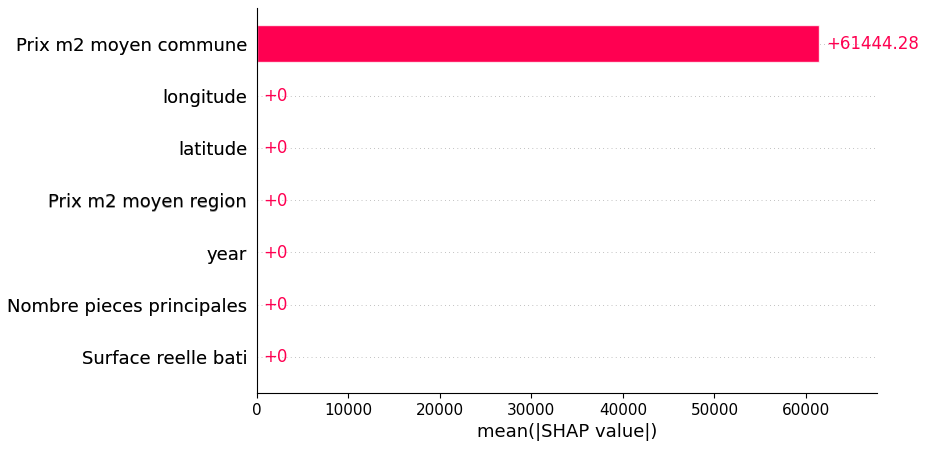

#### Amélioration du modèle

On se rend compte assez vite que le type local influt sur la qualité de la prédiction.  

En effet, les locaux et les dépendances sont des bien atypique (Vendu pour un euros symbolique ou bien avec des valeurs de surfaces egales à zéro).  
On fait le choix arbitraire à ce moment la de creer une régréssion pour les maisons et les appartements, et nous procéderons autrement pour les dépendances et les locaux.


La deuxième observations, c'est sur la **taille des feuilles**.  
Travailler en fraction nous permet de tester facilement notre foret sur 50 000 ou 2 000 000 d'individus.

**Uniquement pour les maisons :**

**RMSE : 65760.98**    
{'min_samples_leaf': 0.05, 'min_samples_split': 0.05}  



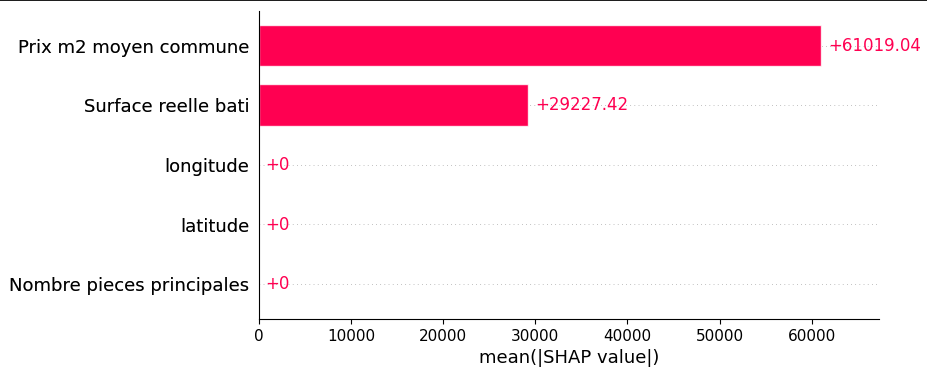


**RMSE : 60251.502**  
{'min_samples_leaf': 0.01, 'min_samples_split': 0.01}  
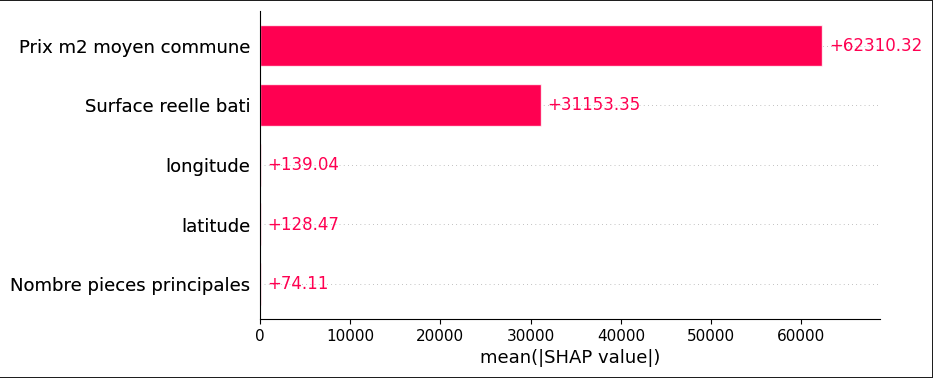

On observe une amélioration des performances des modèles, ainsi qu'une analyse plus fine de la prépondérance des variables. 

En faisant plusieurs tests, on se rend compte que les performances ne s'améliore pas specialement après, on décide donc de rester sur ces paramètres pour ne pas trop complexifier le modèle.  
On va entrainer nos modèles uniquement sur **prix m² des communes**, et la **surface du batiment**.  

Après plusieurs test, on choisit les paramètres suivants :  

- **max_depth=20**
- **min_samples_leaf=0.01**
- **min_samples_split=0.01**
- **n_estimators=50**

On entraine nos modèles avec nos 2 millions d'individus pour obtenir ces résultats :  

##### Maison
Variables utilisées : 'Surface reelle bati', 'Prix m2 moyen commune'  
**RMSE : 58759.54** 


##### Appartement
Variables utilisées : 'Surface reelle bati', 'Prix m2 moyen commune'  
**RMSE : 57856.43** 

Les prédictions des locaux industriels et des dépendances se baseront sur les moyennes des prix des anciennes années, avec un facteur pour simuler l'augmentation des prix.


#### Modèle final

On peut ainsi créer notre modèle final, qui va prendre en variables d'entrée :
- Le type de local
- La surface du bien
- La région
- la commune

Pour évaluer sa cohérence, on l'utilise sur nos données 2018, 2019, 2020 et 2021.  
Cela nous permettra de potentiellement voir des valeurs aberrantes.

| Année | RMSE |
| :-----| :----|
| 2021 | 63294 |
| 2020 | 60597 |
| 2019 | 59448 |
| 2018 | 58813 |

Le modèle nous semble pertinent.